Start by importing the PyTorch components that we'll be using:

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.autograd import Variable
import torch.utils.data as Data

Then some standard library imports:

In [2]:
import numpy as np
import pandas as pd
import pylab as pl
import time

---

This next cell contains all the user defined variables for running our network training.

In [3]:
samples       = ['ggH125_ZZ4lep','llll'] # datafiles for input
epochs        = 100                      # number of training epochs
batch_size    = 32                       # number of samples per batch
input_size    = 2                        # The number of features
num_classes   = 2                        # The number of output classes. In this case: [star, galaxy, quasar]
hidden_size   = 5                        # The number of nodes at the hidden layer
learning_rate = 1e-3                     # The speed of convergence
verbose       = True                     # flag for printing out stats at each epoch

---

First import the data and apply the same pre-processing as outlined in the [ML Tutorial](https://hsf-training.github.io/hsf-training-ml-webpage/).

In [4]:
DataFrames = {} # define empty dictionary to hold dataframes
for s in samples: # loop over samples
    DataFrames[s] = pd.read_csv('./'+s+".csv") # read .csv file

In [5]:
# cut on lepton charge
def cut_lep_charge(lep_charge_0,lep_charge_1,lep_charge_2,lep_charge_3):
# only want to keep events where sum of lepton charges is 0
    sum_lep_charge = lep_charge_0 + lep_charge_1 + lep_charge_2 + lep_charge_3
    if sum_lep_charge==0: return True
    else: return False

# apply cut on lepton charge
for s in samples:
    # cut on lepton charge using the function cut_lep_charge defined above
    DataFrames[s] = DataFrames[s][ np.vectorize(cut_lep_charge)(DataFrames[s].lep_charge_0,
                                                    	    DataFrames[s].lep_charge_1,
                                                    	    DataFrames[s].lep_charge_2,
                                                    	    DataFrames[s].lep_charge_3) ]

---

Then create the *feature* and *target* data arrays that are needed to train the machine learning model. Again this follows the [ML tutorial](https://hsf-training.github.io/hsf-training-ml-webpage/).

In [6]:
ML_inputs = ['lep_pt_1','lep_pt_2'] # list of features for ML model

In [7]:
all_MC = [] # define empty list that will contain all features for the MC

for s in samples: # loop over the different samples
    if s!='data': # only MC should pass this
        all_MC.append(DataFrames[s][ML_inputs]) # append the MC dataframe to the list containing all MC features
        
X = np.concatenate(all_MC) # concatenate the list of MC dataframes into a single 2D array of features, called X

In [8]:
all_y = [] # define empty list that will contain labels whether an event in signal or background

for s in samples: # loop over the different samples
    if s!='data': # only MC should pass this
        if 'H125' in s: # only signal MC should pass this
            all_y.append(np.ones(DataFrames[s].shape[0])) # signal events are labelled with 1
        else: # only background MC should pass this
            all_y.append(np.zeros(DataFrames[s].shape[0])) # background events are labelled 0
            
y = np.concatenate(all_y) # concatenate the list of lables into a single 1D array of labels, called y

In [9]:
from sklearn.model_selection import train_test_split

# make train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                  test_size=0.33, 
                                                  random_state=492 ) # set the random seed for reproducibility

In [10]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler() # initialise StandardScaler

scaler.fit(X_train) # Fit only to the training data

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)
X = scaler.transform(X)

---

Here we're making use of the PyTorch `DataLoader` functionality. This is going to be useful later when we want to load data during our training loop.

In [11]:
X_train  = torch.tensor(X_train, dtype=torch.float)
y_train  = torch.tensor(y_train, dtype=torch.long)

X_train, y_train = Variable(X_train), Variable(y_train)

x_valid, y_valid = X_train[:100], y_train[:100]
x_train_nn, y_train_nn = X_train[100:], y_train[100:]

train_data = Data.TensorDataset(x_train_nn, y_train_nn)
valid_data = Data.TensorDataset(x_valid, y_valid)

train_loader = Data.DataLoader(dataset=train_data,
                               batch_size=batch_size,
                               shuffle=True)

valid_loader = Data.DataLoader(dataset=valid_data,
                               batch_size=batch_size,
                               shuffle=True)

---

Here we define the neural network that we'll be using. This is a simple fully-connected neural network, otherwise known as a *multi-layer perceptron* (MLP). It has two hidden layers, both with the same number of neurons (`hidden_dim`). The order of the layers for a forward pass through the network is specified in the `forward` function. You can see that each fully-connected layer is followed by a [ReLU activation function](https://ml-cheatsheet.readthedocs.io/en/latest/activation_functions.html#relu). The function then returns an unnormalised vector of outputs (`x`; also referred to as *logits*) and a vector of normalised "probabilities" for `x`, calculated using the [SoftMax function](https://ml-cheatsheet.readthedocs.io/en/latest/activation_functions.html#softmax).

In [12]:
class Classifier_MLP(nn.Module):
    def __init__(self, in_dim, hidden_dim, out_dim):
        super().__init__()
        
        self.h1  = nn.Linear(in_dim, hidden_dim)
        self.h2  = nn.Linear(hidden_dim, hidden_dim)
        self.out = nn.Linear(hidden_dim, out_dim)
        self.out_dim = out_dim

    def forward(self, x):
        
        x = F.relu(self.h1(x))
        x = F.relu(self.h2(x))
        x = self.out(x)
        
        return x, F.softmax(x, dim=1)

Next we need to specify that we're using the `Classifier_MLP` model that we specified above and pass it the parameters it requires (`input_size`, `hidden_dim`, `out_dim`). 

We also specify which optimizer we'll use to train our network. Here I've implemented a classic [Stochastic Gradient Descent](https://en.wikipedia.org/wiki/Stochastic_gradient_descent) (SGD) optimiser, but there are [a wide range of optimizers available in the PyTorch library](https://pytorch.org/docs/stable/optim.html#algorithms). For most recent applications the [Adam](https://arxiv.org/abs/1412.6980) optimizer is used.

In [13]:
model = Classifier_MLP(in_dim=input_size, hidden_dim=hidden_size, out_dim=num_classes)
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

The next cell contains the training loop for optimizing the parameters of our neural network. To train the network we loop through the full training data set multiple times. Each loop is called an *epoch*. However, we don't read the full dataset all at once in an individual epoch, instead we split it into *mini-batches* and we use the optimization algorithm to update the network parameters after each batch. 

The `train_loader` that we specified earlier using the PyTorch `DataLoader` breaks up the full dataset into batches automatically and allows us to load the feature data (`x_train`) and the label data (`y_train`) for each batch separately. Moreover, because we specified `shuffle=True` when we defined the `train_loader` the full datasets will be shuffled on each epoch, so that we aren't optimising over an identical sequence of samples in every loop. 

PyTorch models (`nn.Module`) can be set into either training or evaluation mode. For the loop we've defined here this setting does not make any difference as we do not use any layers that perform differently during evaluation (e.g. dropout, batch normalisation, etc. ) However, it's included here for completeness. 

In [14]:
start = time.time()

_results = []
for epoch in range(epochs):  # loop over the dataset multiple times

    # training loop for this epoch
    model.train() # set the model into training mode
    
    train_loss = 0.
    for batch, (x_train, y_train) in enumerate(train_loader):
        
        model.zero_grad()
        out, prob = model(x_train)
        
        loss = F.cross_entropy(out, y_train)
        
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item() * x_train.size(0)
    
    train_loss/= len(train_loader.dataset)

    if verbose:
        print('Epoch: {}, Train Loss: {:4f}'.format(epoch, train_loss))

    # validation loop for this epoch:
    model.eval() # set the model into evaluation mode
    with torch.no_grad():  # turn off the gradient calculations
        
        correct = 0; valid_loss = 0
        for i, (x_valid, y_valid) in enumerate(valid_loader):
            
            out, prob = model(x_valid)
            loss = F.cross_entropy(out, y_valid)
            
            valid_loss += loss.item() * x_valid.size(0)
            
            preds = prob.argmax(dim=1, keepdim=True)
            correct += preds.eq(y_valid.view_as(preds)).sum().item()
            
        valid_loss /= len(valid_loader.dataset)
        accuracy = correct / len(valid_loader.dataset)

    if verbose:
        print('Validation Loss: {:4f}, Validation Accuracy: {:4f}'.format(valid_loss, accuracy))

    # create output row:
    _results.append([epoch, train_loss, valid_loss, accuracy])

results = np.array(_results)
print('Finished Training')
print("Final validation error: ",100.*(1 - accuracy),"%")

end = time.time()
print("Run time [s]: ",end-start)

Epoch: 0, Train Loss: 0.498926
Validation Loss: 0.511915, Validation Accuracy: 0.680000
Epoch: 1, Train Loss: 0.416348
Validation Loss: 0.458114, Validation Accuracy: 0.680000
Epoch: 2, Train Loss: 0.404610
Validation Loss: 0.450099, Validation Accuracy: 0.680000
Epoch: 3, Train Loss: 0.401071
Validation Loss: 0.444710, Validation Accuracy: 0.680000
Epoch: 4, Train Loss: 0.397758
Validation Loss: 0.439354, Validation Accuracy: 0.730000
Epoch: 5, Train Loss: 0.394308
Validation Loss: 0.431247, Validation Accuracy: 0.810000
Epoch: 6, Train Loss: 0.390859
Validation Loss: 0.425267, Validation Accuracy: 0.790000
Epoch: 7, Train Loss: 0.387606
Validation Loss: 0.418356, Validation Accuracy: 0.800000
Epoch: 8, Train Loss: 0.384678
Validation Loss: 0.414951, Validation Accuracy: 0.810000
Epoch: 9, Train Loss: 0.382122
Validation Loss: 0.409372, Validation Accuracy: 0.800000
Epoch: 10, Train Loss: 0.380047
Validation Loss: 0.408139, Validation Accuracy: 0.790000
Epoch: 11, Train Loss: 0.378408

Epoch: 93, Train Loss: 0.370982
Validation Loss: 0.393510, Validation Accuracy: 0.800000
Epoch: 94, Train Loss: 0.370969
Validation Loss: 0.395051, Validation Accuracy: 0.810000
Epoch: 95, Train Loss: 0.370968
Validation Loss: 0.394267, Validation Accuracy: 0.810000
Epoch: 96, Train Loss: 0.370970
Validation Loss: 0.394497, Validation Accuracy: 0.810000
Epoch: 97, Train Loss: 0.370955
Validation Loss: 0.392335, Validation Accuracy: 0.810000
Epoch: 98, Train Loss: 0.370955
Validation Loss: 0.392337, Validation Accuracy: 0.810000
Epoch: 99, Train Loss: 0.370944
Validation Loss: 0.393667, Validation Accuracy: 0.820000
Finished Training
Final validation error:  18.000000000000004 %
Run time [s]:  1025.5836069583893


(100, 4)


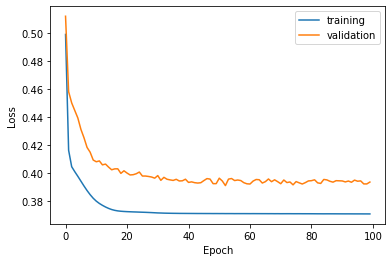

In [15]:
print(results.shape)

pl.subplot(111)
pl.plot(results[:,0],results[:,1], label="training")
pl.plot(results[:,0],results[:,2], label="validation")
pl.xlabel("Epoch")
pl.ylabel("Loss")
pl.legend()
pl.show()